In [9]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import os
from os.path import join as oj
from sklearn import metrics
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
import numpy as np
from collections import Counter
from sklearn.datasets import make_classification
from torch import nn
import torch.nn.functional as F
import torch
from copy import deepcopy
from sklearn import metrics
plt.style.use('dark_background')
import mat4py
import pandas as pd
import data_tracks
import models
from matplotlib_venn import venn3, venn2
from sklearn.model_selection import KFold
from colorama import Fore
import pickle as pkl
import viz
from style import *
import analyze_helper
import train
from sklearn import decomposition
from sklearn.calibration import calibration_curve

outcome_def = 'y_consec_thresh'
out_dir = 'results/jan22_2'
results = analyze_helper.load_results(out_dir)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# compare all models
**baseline stats**

In [10]:
viz.print_metadata(acc=results.accuracy.max())

valid:		1862 aux+ / 7594 (0.245)
----------------------------------------
no_hotspots:	1662 aux+ / 7394 (0.225)
----------------------------------------
lifetime<=26:	4720 aux+ / 5127 (0.921)
lifetime>=236:	   3 aux- /    3 (1.000)
remaining:	1252 aux+ / 2264 (0.553)
----------------------------------------
predicted acc:			  0.691
total acc:			  0.850


**look at prediction metrics**

In [ ]:
r = results
r = r[[k for k in r if not 'std' in k]]
r = r[[k for k in r if not '_f' in k]]
# r = r[r.index.str.contains('ros')] # only use random sampling
r = r.sort_values(by=['accuracy', 'balanced_accuracy'], ascending=False)
# r.style.background_gradient(cmap='viridis', axis=None) # all values on same cmap
r.style.background_gradient(cmap='viridis', axis=0) # columns differently colored
# r.style.apply(viz.highlight_max, subset=[k for k in r if not 'std' in k])

**look at feat importances**

In [ ]:
r = results
# r.style.apply(viz.highlight_max, subset=[k for k in r if not 'std' in k])
r = r[r.accuracy > np.percentile(r.accuracy, 90)]
keys = [k for k in r if '_f' in k]
keys_remapped = {k: k.replace('_f', '') for k in keys}
r = r[keys].rename(columns=keys_remapped)
# r = r.sort_values('lifetime')
# r = r[r.index.str.contains('=5')]
# r = r[~r.index.str.contains('=11')]
# r = r[~r.index.str.contains('=7')]
# r = r[~r.index.str.contains('=15')]
r = r.rename(columns={'mean_square_displacement': 'msd', 'total_displacement': 'td'})

# r = r[r.index.str.contains('11')]
# r = r[r2.index.str.contains('ros')]
# r = r[r.index.str.contains('none')]
r = r[[k for k in r if not 'std' in k]]


def rank(r):
    '''Rank feature importances appropriately
    '''
    r = r.abs()
    r = r.rank(axis=1, ascending=False, method='min')
    return r
# 
r = rank(r)
# r = r.reindex(r.mean().sort_values(ascending=True).index, axis=1) # sort cols by mean rank

idxs = r.index
r.insert(0, 'acc', results.loc[idxs]['accuracy'])
r = r.sort_values('acc', ascending=False)
r = r.reindex(r.iloc[0].sort_values(ascending=True).index, axis=1) # sort cols by mean rank
subset = list(r.keys())
subset.remove('acc')
r.insert(1, 'num_feats', r.apply(lambda row: np.sum(~np.isnan(row.values)) - 1, axis=1))


def color_vals(val):
    colors = {
        1: cb, 2: cp, 3: cr,
    }
    if not val in colors:
        color = 'maroon'
    else:
        color = colors[val]
    return 'color: %s' % color

r.fillna("").style.applymap(color_vals, subset=subset)
# r.fillna(0).style.background_gradient(cmap='viridis_r', axis=1, subset=subset) # rows differently colored

# analyze model predictions

In [11]:
df = data_tracks.get_data()
n = df.shape[0]

# normalize and store
def normalize(df):
    X = df[data_tracks.get_feature_names(df)]
    X_mean = X.mean()
    X_std = X.std()
    ks = list(X.keys())
    norms = {ks[i]: {'mu': X_mean[i], 'std': X_std[i]} for i in range(len(ks))}
    X = (X - X_mean) / X_std
    y = df[outcome_def].values
    return X, y, norms
X, y, norms = normalize(df)



# split testing data based on cell num
# cv_idx = data_tracks.cell_nums_train[0]
# idxs_test = df.cell_num.isin([cv_idx]) # this is the cv set for model's trained in the first cv fold
# X_test, Y_test = X[idxs_test], y[idxs_test]

# look at best models
r = results
r = r.sort_values('accuracy', ascending=False)
idx = np.array(r.index)
accs = np.array(r.accuracy)
for i in range(5):
    print(f'{accs[i]:.3f}', idx[i])
# model_name = 'svm_15_ros=1.2_select_rf=3' # idx[0]
model_name = idx[0]

0.691 mlp2_36_ros=1.2_select_lasso=11
0.691 mlp2_25_ros=1.2_select_lasso=11
0.691 mlp2_16_ros=1.2_select_lasso=11
0.689 svm_36_ros=1.2_select_lasso=11
0.689 svm_16_ros=1.2_select_lasso=11


### look at single model

In [22]:
d_full_cv, idxs_cv = analyze_helper.get_data_over_folds(model_name, out_dir, df.cell_num, X, y)
y_full_cv = df[outcome_def].iloc[idxs_cv].values.astype(np.int)
preds = d_full_cv[model_name].values
preds_proba = d_full_cv[model_name + '_proba'].values

results_individual = pkl.load(open(oj(out_dir, f'{model_name}.pkl'), 'rb'))
assert np.sum(idxs_cv == np.arange(idxs_cv.size)) == idxs_cv.size, \
       'points not in same order'
assert np.mean(preds==y_full_cv) == np.average(results_individual['cv']['accuracy'], 
                                               weights=results_individual['num_pts_by_fold_cv']), \
        'did not properly load model/data'

In [56]:
idxs_cv

array([   0,    1,    2, ..., 1837, 1838, 1839])

In [ ]:
num_to_plot = 3
tp = np.logical_and(preds==1, y_full_cv==1)
tn = np.logical_and(preds==0, y_full_cv==0)
fp = preds > y_full_cv
fn = preds < y_full_cv

print('total pts', preds.shape[0])
for idxs, name in zip([fp, fn, tp, tn], ['fp', 'fn', 'tp', 'tn']):
    print(name, idxs.sum())
    inds = viz.viz_biggest_errs(df, idxs_cv, idxs, y_full_cv, preds, preds_proba, num_to_plot)
    plt.savefig(f'{name}.pdf')
    # plt.show()

In [100]:
fn_pos = [4, 10, 18, 188, 213, 91, 155]
fn_hotspots = [26, 34, 52, 53, 89, 103, 109, 120, 
               145, 146, 162, 165, 173, 179, 182, 190, 198, 199,
               232, 238, 240, 241, 256, 259]
fp_pos = [5, 7, 8, 11, 12, 18, 22, 23, 24, 27, 30, 46, 48, 49, 51, 53, 
          54, 61, 64, 66, 67, 68, 69, 70, 73, 74, 76, 77, 78, 80, 82, 84, 88,
          89, 91, 92, 94, 95, 101, 102, 103, 104, 105, 110, 111, 116, 117, 118, 124,
          127, 130, 132, 134, 136, 141, 144, 145, 146, 147, 149, 150, 152, 158, 163,
          166, 173, 179, 181, 182, 184, 187, 188, 190, 191, 203, 209, 220, 223, 230,
          235, 237, 240, 244, 246, 247, 248, 250, 251, 252, 253, 255, 263, 264, 270,
          275, 276, 277, 279, 280, 283, 286, 287, 292, 294, 295, 298, 301, 304, 305,
          306
         ]
fp_hotspot = [16, 47, 52, 71, 107, 109, 161, 162, 180, 183, 222, 300]
idxs = idxs_cv[fn][fn_hotspots]
df.iloc[idxs].index

Int64Index([ 326, 1311, 1348,  406,  661,  739,  836, 1096, 1111, 1279, 1309,
            1374, 1456, 1510, 1649,  402,  408, 1233, 1319, 1348, 1356, 1734,
            1823],
           dtype='int64')

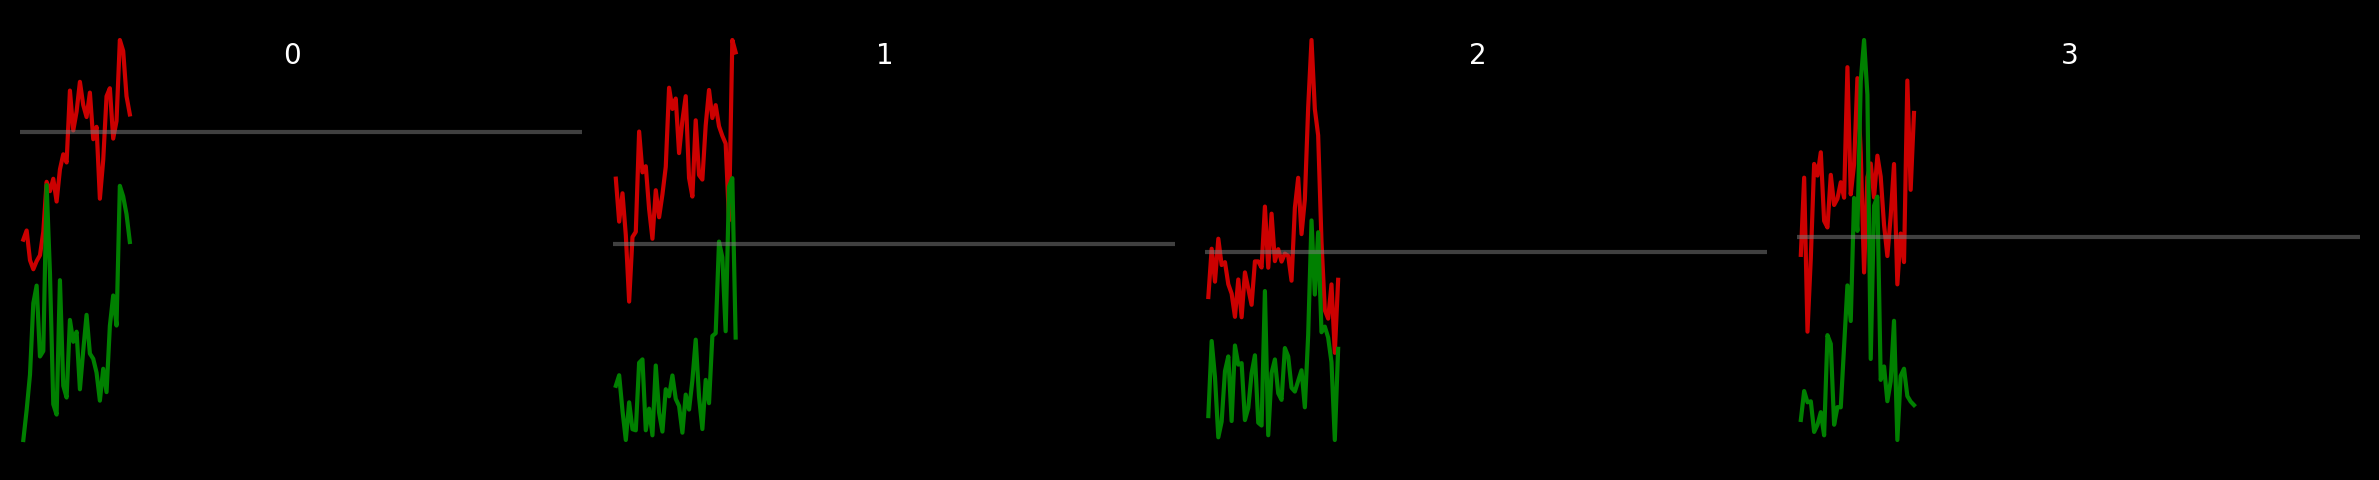

In [136]:
dft = viz.viz_biggest_errs(df, idxs_cv, fn, y_full_cv, 
                           preds, preds_proba, num_to_plot=3)

In [152]:
saved_fn_hotspots = dft.iloc[fn_hotspots].index

In [153]:
saved_fn_pos = dft.iloc[fn_pos].index

In [154]:
saved_fn_hotspots[0]

1358

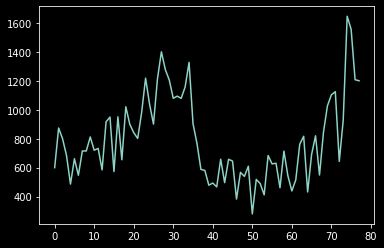

In [147]:
plt.plot(dft_hotspots["X"].iloc[0])

In [158]:
df.loc[saved_fn_hotspots[0]]['X']

1358    [599.6824404192427, 873.919297232887, 799.5213...
1358    [500.2325404496854, 822.3105716986018, 705.712...
Name: X, dtype: object

In [118]:
dft.index

Int64Index([ 862,  630,  207,  944,  852,  731,  895,  839,  668,  777,
            ...
             389,  274, 1051,  705,  759,  344,  294,  399,  230,  504],
           dtype='int64', length=261)

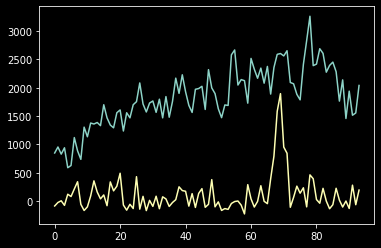

In [122]:
plt.plot(dft['X'].iloc[0])
plt.plot(dft['Y'].iloc[0])

In [108]:
# idxs = np.nonzero(idxs_cv[fn])[0][fn_hotspots]
idxs_bool = np.zeros(idxs_cv.size).astype(np.bool)
idxs_bool[args] = True
args

array([192, 124,   4, 222])

Int64Index([ 197,  201,  205,  206,  207,  219,  221,  225,  229,  230,
            ...
            1811, 1823, 1830, 1837, 1856, 1864, 1873, 1893, 1900, 1903],
           dtype='int64', length=1840)


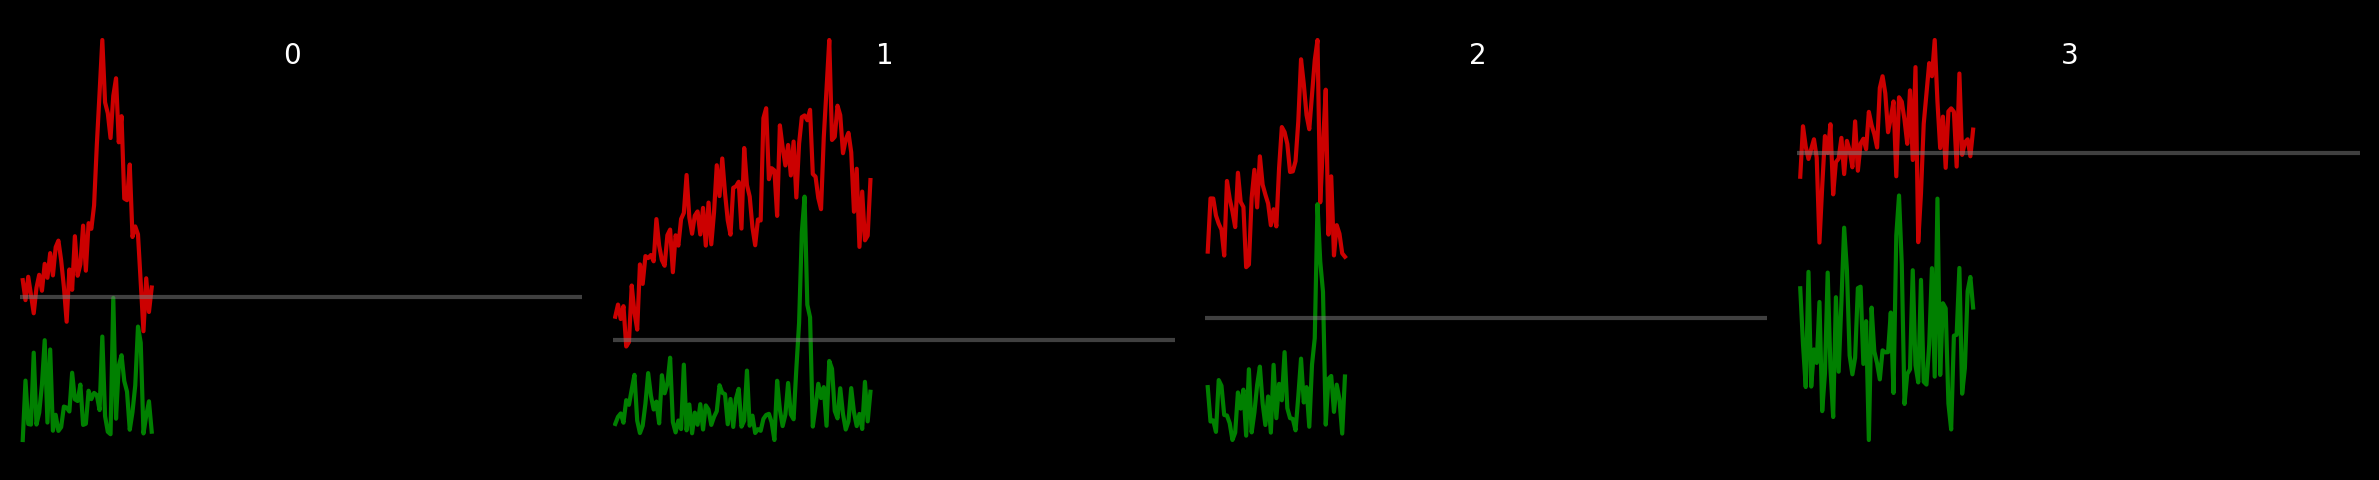

In [110]:
args = viz.viz_biggest_errs(df, idxs_cv, idxs_bool, y_full_cv, 
                            preds, preds_proba, num_to_plot=3)

In [14]:
print('inter-cell accs', np.array(results_individual['cv']['accuracy']).round(2))

inter-cell accs [0.74 0.78 0.72 0.77 0.69]


In [ ]:
dist_to_end = df.iloc[idxs_fp]['lifetime'] - df.iloc[idxs_fp]['Y_peak_idx'] - 1
frac_to_end = 1 - df.iloc[idxs_fp]['Y_peak_idx'] / df.iloc[idxs_fp]['lifetime']
print(np.unique(dist_to_end, return_counts=True))
plt.hist(frac_to_end, bins=100)
plt.show()

In [65]:
# calculate hotspots acc
results_individual = pkl.load(open(oj(out_dir, f'{model_name}.pkl'), 'rb'))
df = data_tracks.get_data(use_processed=False, remove_hotspots=False, save_processed=False)
df = df[df['hotspots']==1]
X, y, norms = normalize(df)

preds, pred_proba = analyze_helper.analyze_individual_results(results_individual, 
                                               X, y, print_results=False, 
                                               plot_results=False, model_cv_fold=1)
print(f'hotspots acc:\t\t\t{np.mean(preds==df[outcome_def])}')

loading + preprocessing data...
	loading tracks...
	preprocessing data...
	adding features...
dict features not added!
hotspots acc:			0.6385542168674698


In [ ]:
key = 'X_max' # lifetime, X_min, fall, X_max
viz.viz_errs_1d(X.iloc[idxs_cv], preds, preds_proba, y_full_cv, norms, key=key)

In [ ]:
key1 = 'X_max' # fall, x_pos, pc1
key2 = 'X_min' # X_min, y_pos, pc2
viz.viz_errs_2d(df, idxs_cv, preds, y_full_cv, key1=key1, key2=key2)
plt.xscale('log')
plt.yscale('log')

In [ ]:
viz.viz_errs_outliers_venn(X.iloc[idxs_cv], preds, y_full_cv, num_feats_reduced=5)

In [ ]:
plt.figure(dpi=200)
prob_true, prob_pred = calibration_curve(y_full_cv, preds_proba, normalize=False, n_bins=10, strategy='quantile')
plt.plot(prob_true, prob_pred, '.')
plt.plot([0, 1], [0, 1], alpha=0.3, color='gray')
plt.xlabel('true prob')
plt.ylabel('predicted prob')
plt.show()

**look at pcs**

In [ ]:
# perform pca
pca = decomposition.PCA(whiten=True)
pca.fit(X.iloc[idxs_cv])
viz.plot_pcs(pca, X.iloc[idxs_cv])

In [ ]:
pca = decomposition.PCA(n_components=2, whiten=True)
X_reduced = pca.fit_transform(X.iloc[idxs_cv])
plt.figure(dpi=200)
ys_neg = y[idxs_cv] == 0
plt.plot(X_reduced[:, 0][ys_neg], X_reduced[:, 1][ys_neg], 'o', 
         color=cr, alpha=0.3, markeredgewidth=0, ms=2)
plt.plot(X_reduced[:, 0][~ys_neg], X_reduced[:, 1][~ys_neg], 'o', 
         color=cb, alpha=0.3, markeredgewidth=0, ms=2)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

### look at many models

In [107]:
# model_names = ['mlp2_11_none', 'svm_35_none', 'logistic_4_none', 'rf_9_none']
# model_names = ['mlp2_11_none', 'mlp2_9_none', 'mlp2_4_none']
model_names = idx[:3]
d_full_cv, idxs_cv = analyze_helper.get_data_over_folds(model_names, out_dir, df.cell_num, X, y)
y_full_cv = df[outcome_def].iloc[idxs_cv].values

**ensemble err**

In [108]:
# ensemble
d_full_cv_probs = d_full_cv[[k for k in d_full_cv.keys() if 'proba' in k]]
preds_soft = d_full_cv_probs.sum(axis=1) / d_full_cv_probs.shape[1]

for score_name in train.scorers.keys():
    print(score_name, train.scorers[score_name](y_full_cv, preds_soft > 0.5))
# metrics.accuracy_score(y_ensemble, preds_soft>0.5) 

balanced_accuracy 0.7307451262767688
accuracy 0.7394094993581515
precision 0.7415254237288136
recall 0.8120649651972158
f1 0.7751937984496123
roc_auc 0.7307451262767688
precision_recall_curve (array([0.55327343, 0.74152542, 1.        ]), array([1.        , 0.81206497, 0.        ]), array([False,  True]))
roc_curve (array([0.        , 0.35057471, 1.        ]), array([0.        , 0.81206497, 1.        ]), array([2, 1, 0]))


**venn-diagram**

In [ ]:
sets = []
for model_name in model_names:
    args = np.argwhere(d_full_cv[model_name] != y_full_cv)
    sets.append(set(args.flatten().tolist()))
    
plt.figure(dpi=300)
plt.title('venn diagram of shared errors')
venn3(sets, model_names[:3])
plt.show()